# Porting an analysis from local to distributed

<a href = "http://yogen.io"><img src="http://yogen.io/assets/logo.svg" alt="yogen" style="width: 200px; float: right;"/></a>

Now comes the opportunity to put in practice what we have just learned!

# Guided exercise

Recreate the boxplot we did in the pandas section, in Spark!

Since matplotlib boxplot needs all the data and that would be unfeasible with Big Data, we will calculate the quartiles ourselves.

Once the analysis is ported, we will be able to run it on the whole historical series! You can find it at https://transtats.bts.gov (On time performance reporting carrier).

##  Workflow

The basic idea is the same that we applied in the Amadeus Challenge:

* Build prototype with small data: in this section, we will be using `06-intro_to_pandas_practical.ipynb` as our already made prototype

* Modify your prototype so that it works with Big Data: In this case, it means porting it to Spark

* Test your "Big Data" prototype with small data: We will first test it with a sample locally, then upload it to a cluster and test it with Big Data.

    * You can run your analyses building your own cluster and storage bucket in Google Cloud Storage. More in notebook #4!

* Run your prototype with Big Data.

    


## Modify the prototype so that it works with Big Data

## Read csv

We'll use the `SparkSession.read.csv` method.

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
df = spark.read.csv('On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_12.csv', 
                    inferSchema=True, 
                    header=True)
df

DataFrame[Year: int, Quarter: int, Month: int, DayofMonth: int, DayOfWeek: int, FlightDate: timestamp, Reporting_Airline: string, DOT_ID_Reporting_Airline: int, IATA_CODE_Reporting_Airline: string, Tail_Number: string, Flight_Number_Reporting_Airline: int, OriginAirportID: int, OriginAirportSeqID: int, OriginCityMarketID: int, Origin: string, OriginCityName: string, OriginState: string, OriginStateFips: int, OriginStateName: string, OriginWac: int, DestAirportID: int, DestAirportSeqID: int, DestCityMarketID: int, Dest: string, DestCityName: string, DestState: string, DestStateFips: int, DestStateName: string, DestWac: int, CRSDepTime: int, DepTime: int, DepDelay: double, DepDelayMinutes: double, DepDel15: double, DepartureDelayGroups: int, DepTimeBlk: string, TaxiOut: double, WheelsOff: int, WheelsOn: int, TaxiIn: double, CRSArrTime: int, ArrTime: int, ArrDelay: double, ArrDelayMinutes: double, ArrDel15: double, ArrivalDelayGroups: int, ArrTimeBlk: string, Cancelled: double, Cancellati

In [6]:
df.schema

StructType(List(StructField(FlightDate,TimestampType,true),StructField(DayOfWeek,IntegerType,true),StructField(Reporting_Airline,StringType,true),StructField(Tail_Number,StringType,true),StructField(Flight_Number_Reporting_Airline,IntegerType,true),StructField(Origin,StringType,true),StructField(OriginCityName,StringType,true),StructField(OriginStateName,StringType,true),StructField(Dest,StringType,true),StructField(DestCityName,StringType,true),StructField(DestStateName,StringType,true),StructField(DepTime,IntegerType,true),StructField(DepDelay,DoubleType,true),StructField(AirTime,DoubleType,true),StructField(Distance,DoubleType,true)))

## Select relevant columns

Literally the same syntax as Pandas!

```python
df = df.select(['FlightDate', 'DayOfWeek', 'Reporting_Airline', 'Tail_Number', 'Flight_Number_Reporting_Airline', 'Origin', 
                'OriginCityName', 'OriginStateName', 'Dest', 'DestCityName', 'DestStateName',
                'DepTime', 'DepDelay', 'AirTime', 'Distance'])

df
```

In [5]:
df = df[['FlightDate', 'DayOfWeek', 'Reporting_Airline', 'Tail_Number', 'Flight_Number_Reporting_Airline', 'Origin', 
                'OriginCityName', 'OriginStateName', 'Dest', 'DestCityName', 'DestStateName',
                'DepTime', 'DepDelay', 'AirTime', 'Distance']]

df

DataFrame[FlightDate: timestamp, DayOfWeek: int, Reporting_Airline: string, Tail_Number: string, Flight_Number_Reporting_Airline: int, Origin: string, OriginCityName: string, OriginStateName: string, Dest: string, DestCityName: string, DestStateName: string, DepTime: int, DepDelay: double, AirTime: double, Distance: double]

### Extract "Hour" variable

The DepTimes have been inferred to be ints. We need them as ints, representing each o fthe 24 hours in a day.

In [7]:
df[['DepTime']].show(5)

+-------+
|DepTime|
+-------+
|   1048|
|    638|
|   1710|
|   1318|
|    953|
+-------+
only showing top 5 rows



In [17]:
from pyspark.sql import types

df2 = df.withColumn('Hour', (df['DepTime'] / 100).cast(types.IntegerType()))

df2.show(5)

+-------------------+---------+-----------------+-----------+-------------------------------+------+--------------+---------------+----+------------+-------------+-------+--------+-------+--------+----+
|         FlightDate|DayOfWeek|Reporting_Airline|Tail_Number|Flight_Number_Reporting_Airline|Origin|OriginCityName|OriginStateName|Dest|DestCityName|DestStateName|DepTime|DepDelay|AirTime|Distance|Hour|
+-------------------+---------+-----------------+-----------+-------------------------------+------+--------------+---------------+----+------------+-------------+-------+--------+-------+--------+----+
|2018-12-25 00:00:00|        2|               WN|     N566WN|                           1823|   OAK|   Oakland, CA|     California| GEG| Spokane, WA|   Washington|   1048|    18.0|  111.0|   723.0|  10|
|2018-12-25 00:00:00|        2|               WN|     N562WN|                            982|   OAK|   Oakland, CA|     California| HOU| Houston, TX|        Texas|    638|    -2.0|  204.0|

## Generate the relative distributions

In order to be able to handle the data, we need to reduce its dimensionality. Since we want to describe a discrete distribution, we can just count how many values of each level of the 'DepDelay' variable we find for each hour (24 different discrete distributions). We also want the totals in order to do the relative distribution.

### Distributions

In [29]:
distributions = df2.groupby('Hour', 'DepDelay').count()
distributions.show(5)

+----+--------+-----+
|Hour|DepDelay|count|
+----+--------+-----+
|  17|     8.0|  388|
|  13|    19.0|  197|
|  22|     9.0|  158|
|  16|    76.0|   31|
|  17|    72.0|   32|
+----+--------+-----+
only showing top 5 rows



### Totals

Now we join both and calculate what fraction of the total for each hour each level of DepDelay represents.

In [28]:
totals = distributions.groupby('Hour').sum('count')
totals.show(5)

+----+----------+
|Hour|sum(count)|
+----+----------+
|  12|     36925|
|  22|     15646|
|null|      6526|
|   1|       846|
|  13|     33163|
+----+----------+
only showing top 5 rows



### Generate distributions

We have to group on the hour. Each group will be a bunch of delays and the corresponding frequencies.

In [33]:
joined = distributions.join(totals, on='Hour')

joined.show(5)

+----+--------+-----+----------+
|Hour|DepDelay|count|sum(count)|
+----+--------+-----+----------+
|  17|     8.0|  388|     36591|
|  13|    19.0|  197|     33163|
|  22|     9.0|  158|     15646|
|  16|    76.0|   31|     34761|
|  17|    72.0|   32|     36591|
+----+--------+-----+----------+
only showing top 5 rows



In [36]:
freqs = joined.withColumn('relative', joined['count'] / joined['sum(count)']).cache()
freqs.show()

+----+--------+-----+----------+--------------------+
|Hour|DepDelay|count|sum(count)|            relative|
+----+--------+-----+----------+--------------------+
|  17|     8.0|  388|     36591|0.010603700363477358|
|  13|    19.0|  197|     33163|0.005940355215149...|
|  22|     9.0|  158|     15646|0.010098427713153522|
|  16|    76.0|   31|     34761|8.918040332556601E-4|
|  17|    72.0|   32|     36591|8.745319887404006E-4|
|   6|    89.0|    4|     37398|1.069575913150435...|
|  23|   108.0|   14|      5835|0.002399314481576692|
|  22|    73.0|   24|     15646| 0.00153393838680813|
|  16|    84.0|   33|     34761|9.493397773366704E-4|
|  18|   -11.0|  435|     33335|0.013049347532623368|
|  17|    86.0|   21|     36591| 5.73911617610888E-4|
|   0|    95.0|   10|      2283|0.004380201489268506|
|  10|    70.0|   18|     34600|5.202312138728323E-4|
|  20|   173.0|    9|     28354|3.174155322000423E-4|
|   7|    52.0|   22|     35336|6.225945211682137E-4|
|  20|   226.0|    4|     28

`functions.collect_list`

These groups are definitely manageable: the number of levels will be on the order of a few hundreds to a couple thousands. We can combine them into lists straight away.

In [38]:
from pyspark.sql import functions

help(functions.collect_list)

Help on function collect_list in module pyspark.sql.functions:

collect_list(col)
    Aggregate function: returns a list of objects with duplicates.
    
    .. note:: The function is non-deterministic because the order of collected results depends
        on order of rows which may be non-deterministic after a shuffle.
    
    >>> df2 = spark.createDataFrame([(2,), (5,), (5,)], ('age',))
    >>> df2.agg(collect_list('age')).collect()
    [Row(collect_list(age)=[2, 5, 5])]
    
    .. versionadded:: 1.6



In [51]:
rel_dists = freqs.groupby('Hour').agg(functions.collect_list('DepDelay').alias('DepDelays'),
                                      functions.collect_list('relative').alias('relatives')).dropna()

rel_dists.show(5)

+----+--------------------+--------------------+
|Hour|           DepDelays|           relatives|
+----+--------------------+--------------------+
|  12|[1315.0, 280.0, 3...|[2.70819228165199...|
|  22|[9.0, 73.0, 383.0...|[0.01009842771315...|
|   1|[270.0, 223.0, 30...|[0.00118203309692...|
|  13|[19.0, 211.0, -18...|[0.00594035521514...|
|  16|[76.0, 84.0, 289....|[8.91804033255660...|
+----+--------------------+--------------------+
only showing top 5 rows



Now it's easy to use a UDF to merge the two lists and sort them.

In [52]:
values = [7, -5, -1, 0, 1, 2, 3, 10]
rels = [.05, .2, .05, .15, .05, .1, .2, .2]

sorted(zip(values, rels))

[(-5, 0.2),
 (-1, 0.05),
 (0, 0.15),
 (1, 0.05),
 (2, 0.1),
 (3, 0.2),
 (7, 0.05),
 (10, 0.2)]

In [55]:
zipsort = functions.udf(lambda a,b: sorted(zip(a, b)))
whole_dists = rel_dists.withColumn('whole', zipsort('DepDelays', 'relatives'))
whole_dists.show()

+----+--------------------+--------------------+--------------------+
|Hour|           DepDelays|           relatives|               whole|
+----+--------------------+--------------------+--------------------+
|  12|[1315.0, 280.0, 3...|[2.70819228165199...|[[Ljava.lang.Obje...|
|  22|[9.0, 73.0, 383.0...|[0.01009842771315...|[[Ljava.lang.Obje...|
|   1|[270.0, 223.0, 30...|[0.00118203309692...|[[Ljava.lang.Obje...|
|  13|[19.0, 211.0, -18...|[0.00594035521514...|[[Ljava.lang.Obje...|
|  16|[76.0, 84.0, 289....|[8.91804033255660...|[[Ljava.lang.Obje...|
|   6|[89.0, 678.0, 540...|[1.06957591315043...|[[Ljava.lang.Obje...|
|   3|[157.0, 11.0, 139...|[0.005, 0.01, 0.0...|[[Ljava.lang.Obje...|
|  20|[173.0, 226.0, 53...|[3.17415532200042...|[[Ljava.lang.Obje...|
|   5|[64.0, 42.0, -19....|[4.42536619905297...|[[Ljava.lang.Obje...|
|  19|[131.0, 330.0, 14...|[2.90641348575857...|[[Ljava.lang.Obje...|
|  15|[238.0, 47.0, 584...|[2.80182679106777...|[[Ljava.lang.Obje...|
|  17|[8.0, 72.0, 86

In [60]:
class Tocoto:
    pass

an_object = Tocoto()
an_object

In [57]:
whole_dists[['whole']].first()

Row(whole='[[Ljava.lang.Object;@12eb6aae, [Ljava.lang.Object;@61fcedf2, [Ljava.lang.Object;@7d34187d, [Ljava.lang.Object;@4b28c29f, [Ljava.lang.Object;@25f7f4e, [Ljava.lang.Object;@4ca918a, [Ljava.lang.Object;@59e0969e, [Ljava.lang.Object;@54518b07, [Ljava.lang.Object;@2d0d2bcc, [Ljava.lang.Object;@7d1bb926, [Ljava.lang.Object;@2092947d, [Ljava.lang.Object;@78432adb, [Ljava.lang.Object;@3cd42d54, [Ljava.lang.Object;@1c267161, [Ljava.lang.Object;@28a33fe4, [Ljava.lang.Object;@4957cdd9, [Ljava.lang.Object;@5474f72a, [Ljava.lang.Object;@7bf639bc, [Ljava.lang.Object;@4a1b6539, [Ljava.lang.Object;@3dd550a6, [Ljava.lang.Object;@4e6b2d91, [Ljava.lang.Object;@41ad639, [Ljava.lang.Object;@15b9592e, [Ljava.lang.Object;@2fe6b5f, [Ljava.lang.Object;@156ec934, [Ljava.lang.Object;@47976ebe, [Ljava.lang.Object;@18382f4b, [Ljava.lang.Object;@696d1b80, [Ljava.lang.Object;@aa948f0, [Ljava.lang.Object;@76373585, [Ljava.lang.Object;@2fac0e7f, [Ljava.lang.Object;@2e9cb111, [Ljava.lang.Object;@6e3292fa, [Lj

Careful! If we keep that string return type, it might be problematic later.

In [62]:
zipsort = functions.udf(lambda a,b: sorted(zip(a, b)), 
                        returnType=types.ArrayType(types.ArrayType(types.DoubleType())))
whole_dists = rel_dists.withColumn('whole', zipsort('DepDelays', 'relatives'))
whole_dists.show()

+----+--------------------+--------------------+--------------------+
|Hour|           DepDelays|           relatives|               whole|
+----+--------------------+--------------------+--------------------+
|  12|[1315.0, 280.0, 3...|[2.70819228165199...|[[-38.0, 2.708192...|
|  22|[9.0, 73.0, 383.0...|[0.01009842771315...|[[-39.0, 6.391409...|
|   1|[270.0, 223.0, 30...|[0.00118203309692...|[[-22.0, 0.001182...|
|  13|[19.0, 211.0, -18...|[0.00594035521514...|[[-32.0, 3.015408...|
|  16|[76.0, 84.0, 289....|[8.91804033255660...|[[-37.0, 2.876787...|
|   6|[89.0, 678.0, 540...|[1.06957591315043...|[[-32.0, 2.673939...|
|   3|[157.0, 11.0, 139...|[0.005, 0.01, 0.0...|[[-19.0, 0.005], ...|
|  20|[173.0, 226.0, 53...|[3.17415532200042...|[[-35.0, 3.526839...|
|   5|[64.0, 42.0, -19....|[4.42536619905297...|[[-24.0, 4.425366...|
|  19|[131.0, 330.0, 14...|[2.90641348575857...|[[-32.0, 3.229348...|
|  15|[238.0, 47.0, 584...|[2.80182679106777...|[[-60.0, 2.801826...|
|  17|[8.0, 72.0, 86

### Calculating the quartiles

We are finally ready to calculate the quartiles! We will use a UDF.

The input to our custom function will be one of the distributions coded like we did: as a list of tuples `(value, relative_frequency)`. The quartiles are defined as the values at which we cross the 0.0, .25, .5, .75 and 1.00 relative frequencies. Since the distributions are ordered, we can just iterate over one while keeping track of what portion of the total distribution we have seen, and annotate where we cross the thresholds.

In [72]:
values = [7, -5, -1, 0, 1, 2, 3, 10]
rels = [.05, .2, .05, .15, .05, .1, .2, .2]

sorted(zip(values, rels))

def quartiles(sorted_freqs):
    
    cumulative = 0
    min_ = sorted_freqs[0][0]
    result = [min_]
    
    for value, rel in sorted_freqs:
        prev = cumulative
        cumulative += rel
        
        if cumulative >= 0.25 and prev < 0.25:
            result.append(value)
        elif cumulative >= 0.5 and prev < 0.5:
            result.append(value)
        elif cumulative >= 0.75 and prev < 0.75:
            result.append(value)
            
    result.append(value)
    
    return result
    

quartiles(sorted(zip(values, rels)))

[-5, -1, 2, 3, 10]

In [77]:
quartiles_udf = functions.udf(quartiles, returnType=types.ArrayType(types.DoubleType()))

Apply to the dataframe:

In [79]:
final_result = whole_dists.select('Hour',
                                  quartiles_udf('whole'))

final_result.toPandas()

,Hour,quartiles(whole)
0,12,"[-38.0, -5.0, -2.0, 6.0, 1371.0]"
1,22,"[-39.0, -5.0, 0.0, 22.0, 953.0]"
2,1,"[-22.0, -3.0, 13.0, 111.0, 1154.0]"
3,13,"[-32.0, -5.0, -2.0, 9.0, 1185.0]"
4,16,"[-37.0, -5.0, -1.0, 10.0, 672.0]"
5,6,"[-32.0, -6.0, -3.0, -1.0, 1229.0]"
6,3,"[-19.0, -7.0, -1.0, 30.0, 596.0]"
7,20,"[-35.0, -5.0, 0.0, 19.0, 865.0]"
8,5,"[-24.0, -7.0, -4.0, -2.0, 1320.0]"
9,19,"[-32.0, -5.0, -1.0, 15.0, 847.0]"


### Plotting

We got it! Let's move this over to Pandas for convenient handling

In [80]:
pd_df = final_result.toPandas()
pd_df

,Hour,quartiles(whole)
0,12,"[-38.0, -5.0, -2.0, 6.0, 1371.0]"
1,22,"[-39.0, -5.0, 0.0, 22.0, 953.0]"
2,1,"[-22.0, -3.0, 13.0, 111.0, 1154.0]"
3,13,"[-32.0, -5.0, -2.0, 9.0, 1185.0]"
4,16,"[-37.0, -5.0, -1.0, 10.0, 672.0]"
5,6,"[-32.0, -6.0, -3.0, -1.0, 1229.0]"
6,3,"[-19.0, -7.0, -1.0, 30.0, 596.0]"
7,20,"[-35.0, -5.0, 0.0, 19.0, 865.0]"
8,5,"[-24.0, -7.0, -4.0, -2.0, 1320.0]"
9,19,"[-32.0, -5.0, -1.0, 15.0, 847.0]"


And we are ready to plot!

In [84]:
first = pd_df.loc[0]
first

Hour                                              12
quartiles(whole)    [-38.0, -5.0, -2.0, 6.0, 1371.0]
Name: 0, dtype: object

In [87]:
first['Hour']

12

In [86]:
first['quartiles(whole)']

[-38.0, -5.0, -2.0, 6.0, 1371.0]

(-50, 50)

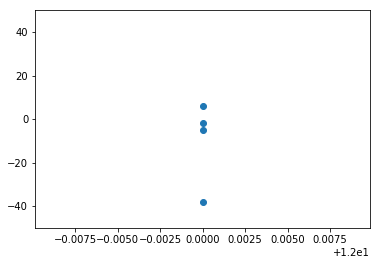

In [93]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter([first['Hour']] * 5, first['quartiles(whole)'])
plt.ylim(-50, 50)

(-50, 50)

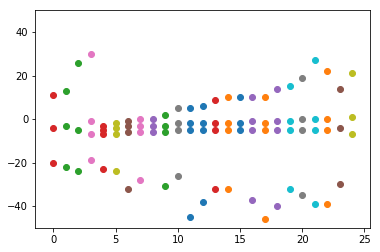

In [109]:
for index, hour in enumerate(pd_df['Hour']):
    quartiles = pd_df.loc[index]['quartiles(whole)']
    plt.scatter([hour] * 5, quartiles)
    
plt.ylim(-50, 50)

## Test your "Big Data" prototype with small data

### Summary

This is the whole process, collected in one place as is:

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
df = spark.read.csv('On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_12.csv', 
                    inferSchema=True, 
                    header=True)
df

df = df[['FlightDate', 'DayOfWeek', 'Reporting_Airline', 'Tail_Number', 'Flight_Number_Reporting_Airline', 'Origin', 
                'OriginCityName', 'OriginStateName', 'Dest', 'DestCityName', 'DestStateName',
                'DepTime', 'DepDelay', 'AirTime', 'Distance']]

df

from pyspark.sql import types

df2 = df.withColumn('Hour', (df['DepTime'] / 100).cast(types.IntegerType()))

df2.show(5)


distributions = df2.groupby('Hour', 'DepDelay').count()
distributions.show(5)

totals = distributions.groupby('Hour').sum('count')
totals.show(5)

joined = distributions.join(totals, on='Hour')

joined.show(5)

freqs = joined.withColumn('relative', joined['count'] / joined['sum(count)']).cache()
freqs.show()

from pyspark.sql import functions

help(functions.collect_list)

rel_dists = freqs.groupby('Hour').agg(functions.collect_list('DepDelay').alias('DepDelays'),
                                      functions.collect_list('relative').alias('relatives')).dropna()

rel_dists.show(5)

zipsort = functions.udf(lambda a,b: sorted(zip(a, b)), 
                        returnType=types.ArrayType(types.ArrayType(types.DoubleType())))
whole_dists = rel_dists.withColumn('whole', zipsort('DepDelays', 'relatives'))
whole_dists.show()

values = [7, -5, -1, 0, 1, 2, 3, 10]
rels = [.05, .2, .05, .15, .05, .1, .2, .2]

sorted(zip(values, rels))

def quartiles(sorted_freqs):
    
    cumulative = 0
    min_ = sorted_freqs[0][0]
    result = [min_]
    
    for value, rel in sorted_freqs:
        prev = cumulative
        cumulative += rel
        
        if cumulative >= 0.25 and prev < 0.25:
            result.append(value)
        elif cumulative >= 0.5 and prev < 0.5:
            result.append(value)
        elif cumulative >= 0.75 and prev < 0.75:
            result.append(value)
            
    result.append(value)
    
    return result
    

quartiles(sorted(zip(values, rels)))

quartiles_udf = functions.udf(quartiles, returnType=types.ArrayType(types.DoubleType()))

final_result = whole_dists.select('Hour',
                                  quartiles_udf('whole'))

final_result.write.json('out.json')

Now we have to clean it up

In [ ]:
from __future__ import print_function
from pyspark.sql import SparkSession,types, functions
import sys

def quartiles(sorted_freqs):
    
    cumulative = 0
    min_ = sorted_freqs[0][0]
    result = [min_]
    
    for value, rel in sorted_freqs:
        prev = cumulative
        cumulative += rel
        
        if cumulative >= 0.25 and prev < 0.25:
            result.append(value)
        elif cumulative >= 0.5 and prev < 0.5:
            result.append(value)
        elif cumulative >= 0.75 and prev < 0.75:
            result.append(value)
            
    result.append(value)
    
    return result
    
if __name__=='__main__':
    
    in_ = sys.argv[1]
    out_ = sys.argv[2]
    
    spark = SparkSession.builder.getOrCreate()

    df = spark.read.csv(in_, 
                        inferSchema=True, 
                        header=True)
    df = df[['FlightDate', 'DayOfWeek', 'Reporting_Airline', 'Tail_Number', 'Flight_Number_Reporting_Airline', 'Origin', 
                    'OriginCityName', 'OriginStateName', 'Dest', 'DestCityName', 'DestStateName',
                    'DepTime', 'DepDelay', 'AirTime', 'Distance']]

    df2 = df.withColumn('Hour', (df['DepTime'] / 100).cast(types.IntegerType()))

    distributions = df2.groupby('Hour', 'DepDelay').count()
    totals = distributions.groupby('Hour').sum('count')
    joined = distributions.join(totals, on='Hour')
    freqs = joined.withColumn('relative', joined['count'] / joined['sum(count)'])
    rel_dists = freqs.groupby('Hour').agg(functions.collect_list('DepDelay').alias('DepDelays'),
                                          functions.collect_list('relative').alias('relatives')).dropna()


    zipsort = functions.udf(lambda a,b: sorted(zip(a, b)), 
                            returnType=types.ArrayType(types.ArrayType(types.DoubleType())))
    whole_dists = rel_dists.withColumn('whole', zipsort('DepDelays', 'relatives'))
    quartiles_udf = functions.udf(quartiles, returnType=types.ArrayType(types.DoubleType()))
    final_result = whole_dists.select('Hour',
                                      quartiles_udf('whole'))

    final_result.write.json(out_)

In [4]:
__name__

'__main__'

### Pyspark job

In order to run the process in a cluster, we need to transform it into a pyspark job file. 

We need to tidy up the function definitions, add the relevant imports, and modify the input and output to use command-line arguments.

We will put the result in a file called mysparkjob.py:

```python
from __future__ import print_function
from pyspark.sql import types, functions, SparkSession
import sys

def zipsort(a, b):
    return sorted(zip(a, b))

def quartiles(histogram):
    area = 0
    result = []
    
    for value, percentage in histogram:
        if area == 0:
            result.append(value)
        elif area <= .25 and area + percentage > .25:
            result.append(value)
        elif area <= .5 and area + percentage > .5:
            result.append(value)
        elif area <= .75 and area + percentage > .75:
            result.append(value)
        area += percentage
    
    result.append(value)
    return result

if __name__=='__main__':
    
    file = sys.argv[1]
    out = sys.argv[2]
    
    spark = SparkSession.builder.getOrCreate()
    df = spark.read.csv(file, header= True, inferSchema=True)
    df = df.select(['FlightDate', 'DayOfWeek', 'Reporting_Airline', 'Tail_Number', 'Flight_Number_Reporting_Airline', 'Origin', 
                    'OriginCityName', 'OriginStateName', 'Dest', 'DestCityName', 'DestStateName',
                    'DepTime', 'DepDelay', 'AirTime', 'Distance'])

    df2 = df.withColumn('Hour', (df['DepTime'] / 100).cast(types.IntegerType()))
    totals = df2.groupBy('Hour').count()
    distributions = df2.groupBy(['Hour', 'DepDelay']).count()
    annotated = distributions.join(totals, on='Hour')
    frequencies = annotated.withColumn('relative', distributions['count'] / totals['count'])
    groups = frequencies.groupBy(totals['Hour'])\
                        .agg(functions.collect_list('DepDelay').alias('delays'),
                             functions.collect_list('relative').alias('relatives'))



    zipsort_typed = functions.udf(zipsort, types.ArrayType(types.ArrayType(types.FloatType())))
    distributions = groups.withColumn('distributions', zipsort_typed('delays', 'relatives'))



    quartiles_udf = functions.udf(quartiles, returnType=types.ArrayType(types.FloatType()))

    result = distributions.select('Hour',
                                  quartiles_udf('distributions').alias('quartiles'))

    result.write.json(out)
    spark.stop()
```

In [6]:
import modulochachi

HOli!
Adiosi!


In [7]:
modulochachi.cuenta_hasta_3()

1
2
3


In [1]:
print(__name__)

__main__


In [2]:
import modulochachi

HOli!
Adiosi!
modulochachi


In [1]:
import modulochachi

In [2]:
modulochachi.cuenta_hasta_3()

1
2
3


### Running with spark-submit

If the following works, we are ready to test it in the cluster!

```python
unset PYSPARK_DRIVER_PYTHON
spark-submit mysparkjob.py On_Time_On_Time_Performance_2015_8.csv out.csv
```